# Stack Overflow Dataset 2017: A look into the career of Data Science
Every year, Stack Overflow conducts a massive survey of people on the site, covering all sorts of information like programming languages, salary, code style and various other information. This year, they amassed more than 64,000 responses fielded from 213 countries. Find the dataset [here](https://www.kaggle.com/stackoverflow/so-survey-2017).

## Introduction
This is an open-ended Exploratory Data Analysis project for the Data Science program at [K2 Data Science](http://k2datascience.com). 

## Goals
The overall goal is to gain insight into the careers of Data Scientist. Of particular focus are the factors that influence a data scientist's salary and the tools data scientists use. I adress the overall goal through 5 specific questions: 
1. How do data science salaries compare to other career salaries? 
2. How are data science salaries effected by years of programming experience? 
3. What are the most popular languages and tools among data scientists?
4. As a data scientist does the language you work in impact your salary?
5. Across all stack overflow users what are the most popular IDEs and how does it break down by experience level?


## Assumptions
* Stack overflow's data is representative of the community of data scientists
* All salaries listed are in USD
* Years spent programming is a good indicator of professional experience as opposed to years spent coding as a job

## What's in the data? 
survey_results_schema.csv lists each survey question in long form. There are a total of 155 different Questions. The questions used for analysis are:
* DeveloperType -> Which of the following best describe you?
* Salary -> What is your current annual base salary, before taxes, and excluding bonuses, grants, or other compensation?    
* YearsProgram -> How long has it been since you first learned how to program?      
* HaveWorkedLanguage -> Which of the following languages have you done extensive development work in over the past year? 

There are numerous useful Questions in the dataset and a plethora of insight questions beyond what is listed in the goals section. Further analysis insight questions can be found in the concluding section.

## Cleaning and Exploring the Data
The data is relatively clean in its native form, however, there were two important preprocessing tasks:
1. Convert YearsProgram from its current form of "5 to 6 years" to a true numeric value
2. Convert DeveloperType and HaveWorkedLanguage whose responses are multianswer separated by ; into dummy variables

Task 2) could not be completed using pandas builtin [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) since the columns contained lists. Therefore, a custom function createDummies was created.

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.float_format = "{:.2f}".format # two decimal places

### helper functions ##
flatten = lambda l: [item for sublist in l for item in sublist]  ## takes a list(list) -> list


def createDummies(column, _data):
    _data[column].fillna("", inplace=True)
    uniqueVals = set(flatten(list(map(lambda str: str.split("; "),
                                      list(_data[column].unique())))))
    uniqueVals.remove("")

    _dummies = pd.DataFrame(0, index=_data.index, columns=uniqueVals)

    for dummyCol in _dummies.columns:
        dummies = so_data[column].map(lambda row: dummyCol in row)
        _dummies[dummyCol] = dummies

    return _dummies, uniqueVals


############# Preprocess Data #############
### Read data ###
so_data = pd.read_csv("data/survey_results_public.csv")

### common column names and variables ###
devType = "DeveloperType"
salary = "Salary"
dScien = "Data scientist"
experience = "YearsProgram"
language = "HaveWorkedLanguage"
jobT = "Job Title"
years = "YearsProgram"
yearsN = "YearsProgramNumeric"
ide = "IDE"
stats_long_name = 'Developer with a statistics or mathematics background'
stats_short_name = "Stats/Math Background"
emb_long_name = 'Embedded applications/devices developer'
emb_short_name = "Embedded Systems"

job_dummies, jobTitles = createDummies(devType, so_data)
language_dummies, languageTitles = createDummies(language, so_data)

year_conversions = {"Less than a year": 0,
                    "1 to 2 years": 2,
                    "2 to 3 years": 3,
                    "3 to 4 years": 4,
                    "4 to 5 years": 5,
                    "5 to 6 years": 6,
                    "6 to 7 years": 7,
                    "7 to 8 years": 7,
                    "8 to 9 years": 9,
                    "9 to 10 years": 10,
                    "10 to 11 years": 11,
                    "11 to 12 years": 12,
                    "12 to 13 years": 13,
                    "13 to 14 years": 14,
                    "14 to 15 years": 15,
                    "15 to 16 years": 16,
                    "16 to 17 years": 17,
                    "17 to 18 years": 18,
                    "18 to 19 years": 19,
                    "20 or more years": 20
                    }
years_numeric = so_data[years].map(year_conversions)
years_numeric.name = yearsN
so_data = so_data.join(years_numeric)

### How do data science salaries compare to other career salaries?
We begin with the question: How do data science salaries compare to other career salaries? To begin answering this question, we first calculate the average salary for different job types. Next, we look at the distribution for each job type in the form of a histogram.


In [104]:
sal_v_type = pd.melt(so_data.join(job_dummies).loc[:, [salary] + list(jobTitles)], id_vars=salary).dropna()
sal_v_type = sal_v_type[sal_v_type["value"]]
del sal_v_type["value"]
sal_v_type.columns = [salary, jobT]

sal_v_type.loc[sal_v_type[jobT] == stats_long_name, jobT] = stats_short_name
sal_v_type.loc[sal_v_type[jobT] == emb_long_name, jobT] = emb_short_name

output = sal_v_type.groupby(jobT)[salary].mean().sort_values(ascending=False).to_frame()
output.columns = ["Average Salary"]
output

,Average Salary
Job Title,
Other,72344.57
DevOps specialist,66158.20
Machine learning specialist,66023.10
Stats/Math Background,62455.50
Data scientist,61137.33
Embedded Systems,58524.35
Quality assurance engineer,56423.11
Desktop applications developer,56352.86
Systems administrator,56331.94


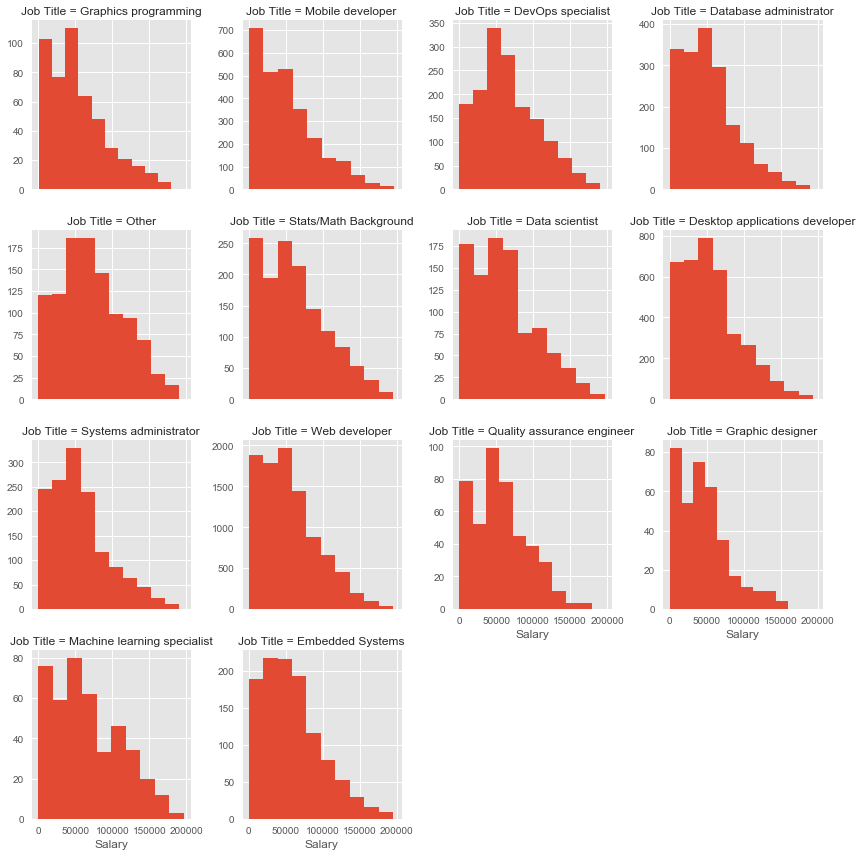

In [105]:
g = sns.FacetGrid(sal_v_type, col=jobT, col_wrap=4, sharey=False)
g = g.map(plt.hist, salary)

#### Findings
In general, it seems that Data Scientists, Machine Learning engineers, and stats/math programmers have some of the highest average salaries of the surveyed users. Seems like you made the right decision getting into data science with K2! Also, the distribution of salary for each job type is visually similar. The only exception seems to be DevOps specialists whose distribution is not left skewed.  

### How are data science salaries effected by years of programming experience?
It is not enough to say that Data Scientists make more money than other technical professionals without incorporating experience. What if all the Data Scientists surveyed were 10+ year veterans of the industry? In this analysis, years programming is used as a surrogate to indicate expereience level. To exlpore how experience effects salary we answer two questions:
1. What is the average salary of data scientists at each experience level and how does this compare to the average across all other job types? 
2. What is the relationship between experience and salary for each job type individually?

In [106]:
diff_in_salary = so_data.join(job_dummies).groupby([years, dScien])[salary].mean()
gain = (diff_in_salary.shift(-1) - diff_in_salary)[::2].reset_index(1, drop=True).sort_values(ascending=False).to_frame()
gain.columns = ["Average gain in salary: average(DS) - average(All other groups)"]
gain

,Average gain in salary: average(DS) - average(All other groups)
YearsProgram,
Less than a year,31647.34
1 to 2 years,15494.99
3 to 4 years,10563.22
14 to 15 years,10504.60
18 to 19 years,10149.81
6 to 7 years,7529.56
7 to 8 years,5817.80
19 to 20 years,5714.87
16 to 17 years,4881.80


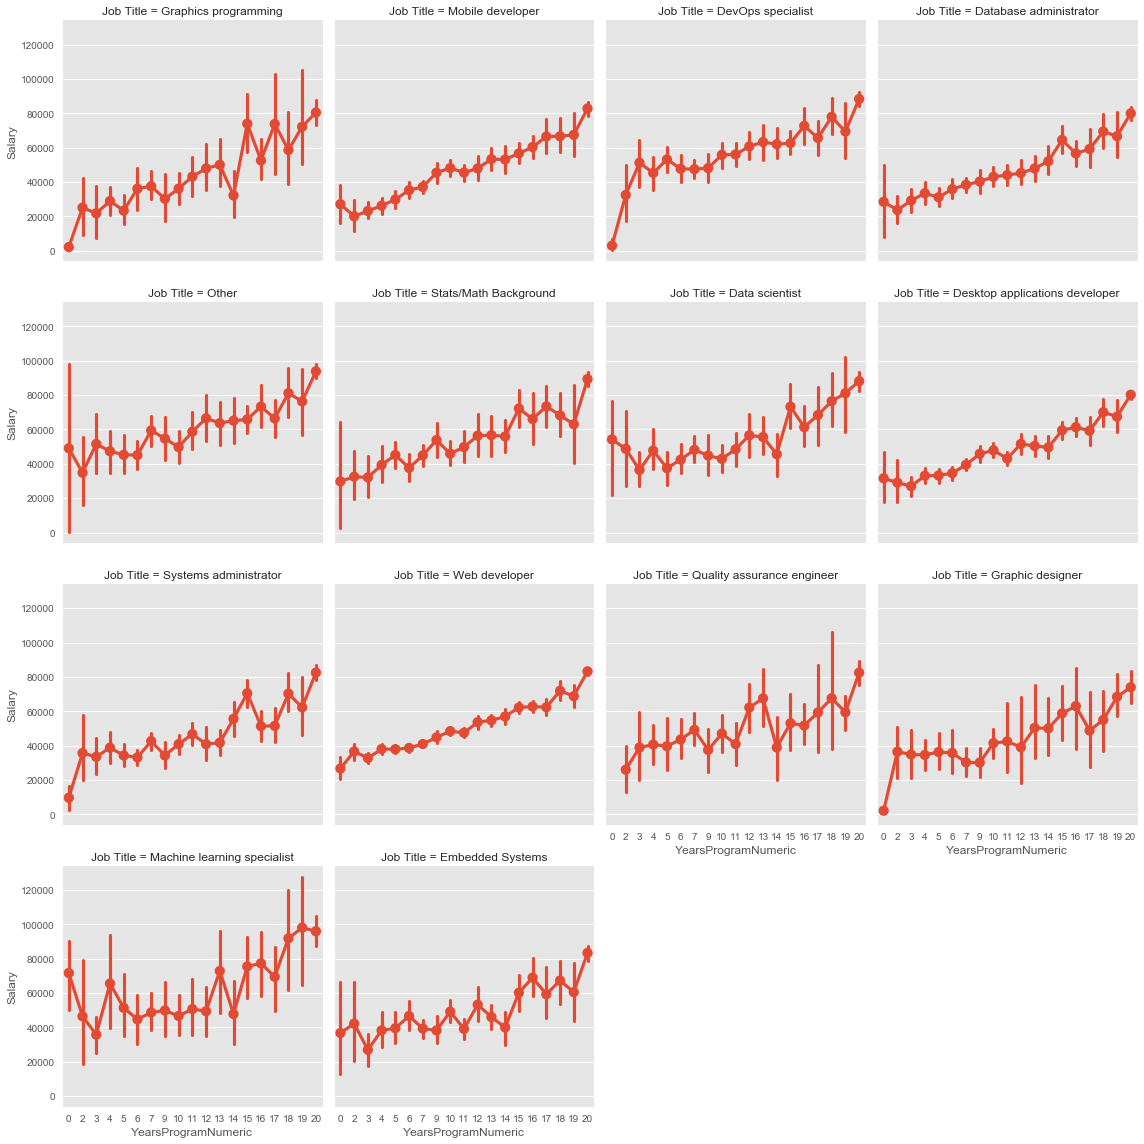

In [37]:
joiners = [salary, yearsN]
sal_exp_v_type = pd.melt(so_data.join(job_dummies).loc[:, joiners + list(jobTitles)],
                         id_vars=joiners).dropna()
sal_exp_v_type = sal_exp_v_type[sal_exp_v_type["value"]]
del sal_exp_v_type["value"]
sal_exp_v_type.columns = [salary, yearsN, jobT]

sal_exp_v_type.loc[sal_exp_v_type[jobT] == stats_long_name, jobT] = stats_short_name
sal_exp_v_type.loc[sal_exp_v_type[jobT] == emb_long_name, jobT] = emb_short_name

sal_exp_v_type[yearsN] = sal_exp_v_type[yearsN].astype(int)

# In general it seems being a Data Scientist, machine learning eingeering, or stats/math programmer increases your pay
sns.factorplot(x="YearsProgramNumeric", y="Salary", col="Job Title", data=sal_exp_v_type, col_wrap=4).savefig(
    "stuff.png")

#### Findings
The table and chart above show some interesting and exciting conclusions for Data Scientists.

First, when looking at the difference in the average salary between Data Scientists and all other groups, it seems that getting a data science title early in your programming career can boost your salary. The boost in salary is most intense for very new programmers (<= 4 years), and very experienced programmers. The only negative gain in average salary appears in programmers well into their careers (9+ years). 

The second chart is a point plot in [seaborn](http://seaborn.pydata.org/). It shows point estimates and confidence intervals. For web, mobile, and desktop application developers salary linearly increases with the number of years of programming experience. Furthermore, there is a very tight confidence interval for the estimate of the mean salary for these job types.

For data scientists, the relationship between programming experience and salary is much less linear and the confidence interval at each experience level is much wider. This makes sense because programming experience is not the only prerequisite for the job of a Data Scientist. Data Science incorporates statistics, machine learning, visualization, and data analytics. Looking solely at programming experience does not give us a good estimate of the salary of a Data Scientist. This is great for new programmers who are interested in breaking into the field. The data shows that even with little programming experience you can gain the title of Data Scientist and there are still opportunities for high paying salaries.  

### What are the most popular languages among data scientists?
First we will look at the most popular languages among data scientists and then the most popular languages among all surveyed users.

In [107]:
datascience_data = so_data[so_data.loc[:, devType].str.contains(dScien, na=False)]

dscien_langauge_dummies, dscien_lang = createDummies(language, datascience_data)
ds_lang = (dscien_langauge_dummies.sum(0).sort_values(ascending=False) / len(dscien_langauge_dummies) * 100.).to_frame()
ds_lang.columns = ["% Data Scientists reported working with the language in the last year"]
ds_lang



/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,% Data Scientists reported working with the language in the last year
Java,55.47
SQL,46.17
JavaScript,45.29
C,43.91
Python,38.49
C#,25.12
C++,22.30
PHP,20.72
R,19.11
Scala,7.65


In [108]:
_langauge_dummies, _lang = createDummies(language, so_data)
_lang = (_langauge_dummies.sum(0) / len(_langauge_dummies) * 100).sort_values(ascending=False).to_frame()
_lang.columns = ["% ALL USERS reported working with the language in the last year"]
_lang

,% ALL USERS reported working with the language in the last year
Java,54.77
JavaScript,44.51
C,41.20
SQL,36.49
C#,24.28
Python,22.77
PHP,20.02
C++,15.87
R,9.83
TypeScript,6.79


#### Findings
Data Scientists and all users use similar languages. Java and javascript appear in the top languages in both groups. However, we see an approximately 16% increase in the use of python, 10% increase in the use of R, and 10% increase in the use of SQL. This makes sense. R and python are considered the most data science specific languages, and data scientists often need to interact with databases and use SQL.

### As a data scientist does the language you work in impact your salary?
As we saw in the last section R and Python are more popular among Data Scientists compared to all stack overflow users. Let's look at the salary breakdown for R and Python. For this analysis, 3 groups were formed: 
1) use R and not Python 
2) use Python and not R
3) use Python and R

In [115]:
rName = "r_only"
pName = "python_only"
bothName = "python_and_r"
r_only = _langauge_dummies["R"] & (~_langauge_dummies["Python"])
r_only.name = rName
python_only = (_langauge_dummies["Python"]) & (~_langauge_dummies["R"])
python_only.name = pName
python_and_r = (_langauge_dummies["Python"]) & (_langauge_dummies["R"])
python_and_r.name = bothName

s_ds_lang = so_data.join([r_only, python_only, python_and_r]).loc[:, [salary, yearsN, rName, pName, bothName]].melt(
    id_vars=[salary, yearsN])
s_ds_lang = s_ds_lang[s_ds_lang["value"]]
del s_ds_lang["value"]
s_ds_lang.columns = [salary, "Years Programming", "Type"]
output = s_ds_lang.groupby("Type")[salary].mean().sort_values(ascending=False).to_frame()
output.columns = ["Mean Salary"]
output

,Mean Salary
Type,
python_and_r,66394.96
r_only,64807.30
python_only,60361.45


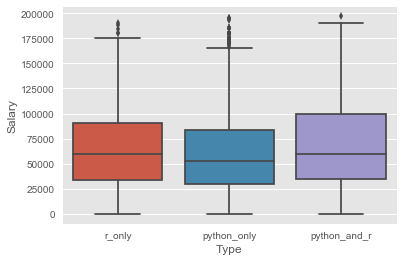

In [116]:
sns.boxplot(x="Type", y=salary, data=s_ds_lang)

In [118]:
s_ds_lang.groupby("Type")["Years Programming"].mean().sort_values(ascending=False).to_frame()

,Years Programming
Type,
r_only,10.91
python_and_r,10.64
python_only,10.56


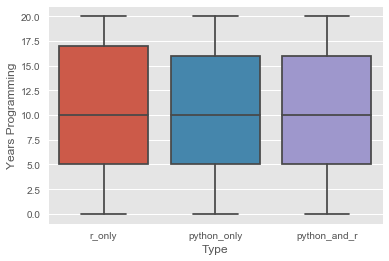

In [117]:
sns.boxplot(x="Type", y="Years Programming", data=s_ds_lang)

#### Findings
For both median and mean salaries, Python and R > R only > Python only. Maybe it pays to learn more than one data science language. Additionally, the mean and median years programming is about the same for each group, so it cannot be explained away with experience. 

### Across all stack overflow users what are the most popular IDEs and how does it break down by experience level?
First we start by looking at the most popular IDEs among data scientists and all users. Next we look at IDE choice when accounting for years spent programming.


In [130]:
dscien_ide_dummies, ides = createDummies(ide, datascience_data)
output = (dscien_ide_dummies.sum(0) / len(dscien_ide_dummies) * 100).sort_values(ascending=False).to_frame()
output.columns = ["% Data Scientists regularly use IDE"]
output

/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,% Data Scientists regularly use IDE
Visual Studio,29.69
Notepad++,26.08
Vim,25.85
Sublime Text,20.43
Eclipse,18.69
IntelliJ,18.33
IPython / Jupyter,13.40
Atom,13.30
PyCharm,12.61
Android Studio,11.89


In [125]:
_ide_dummies, ides = createDummies(ide, so_data)
output = (_ide_dummies.sum(0) / len(_ide_dummies) * 100).sort_values(ascending=False).to_frame()
output.columns = ["% ALL USERS regularly use IDE"]
output

,% ALL USERS regularly use IDE
Visual Studio,31.25
Notepad++,24.68
Sublime Text,19.42
Vim,18.83
Eclipse,15.37
IntelliJ,14.43
Visual Studio Code,13.28
Atom,12.73
Android Studio,11.58
Xcode,7.49


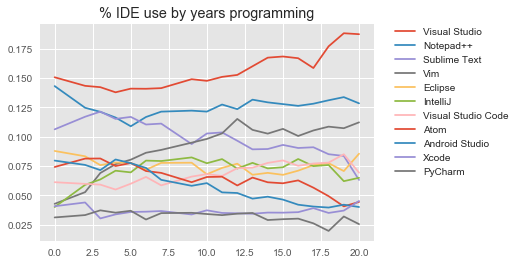

In [144]:
joinerz = list(ides) + [yearsN]
ide_v_yearsN = so_data.join(_ide_dummies).loc[:, joinerz].melt(id_vars=yearsN)
ide_v_yearsN = ide_v_yearsN[ide_v_yearsN["value"]]
del ide_v_yearsN["value"]
ide_v_yearsN.columns = [yearsN, ide]

popular_ides = list(_ide_dummies.sum().sort_values(ascending=False)[0:11].index)

ide_across_years = pd.crosstab(index=ide_v_yearsN[yearsN], columns=ide_v_yearsN[ide])
ide_across_years = ide_across_years.div(ide_across_years.sum(1), axis=0)
popular_ides_v_years = ide_across_years[popular_ides]

handlez = plt.plot(popular_ides_v_years)
plt.title("% IDE use by years programming")
plt.legend(handles=handlez, labels=popular_ides, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Findings
Not surprisely we see an approximately 6% increase in the use of PyCharm, 10% increase in the use of juypter notebooks, and a 7% increase in the use of RStudio. Finally, looking at IDE use across experience levels we conclude [VIM is for old people] (https://meta.stackoverflow.com/questions/350926/2017-survey-vim-is-for-old-people-joking/350935#350935) : ). 


## Conculsion
This notebook was largely concerned with exploring what effects a person's data science salary. It seems like it is an exciting time to be a data scientist and you are often paid more than your peers. Furthermore, data science salaries are less influenced by programming experience than other job types. This is a good sign for inexperienced coders and those trying to break into the field. Future analysis should focus on incorporating education experience and other factors into explaining data science salaries. Additionally, we could dig deeper into the tools used by data scientists by looking at their responses about database, platforms, and frameworks.